In [1]:
from mocpy import MOC
import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord

%matplotlib inline

In [2]:
# Plot the polygon vertices on a matplotlib axis
def plot_graph(vertices):
    import matplotlib.pyplot as plt
    from matplotlib import path, patches
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    p = path.Path(vertices)
    patch = patches.PathPatch(p, facecolor='orange', lw=2)
    ax.add_patch(patch)

In [26]:
# Methods for defining random polygons
def generate_rand_polygon(num_points):
    lon_min, lon_max = (-5, 5)
    lat_min, lat_max = (-5, 5)
    lon = (np.random.random(num_points) * (lon_max - lon_min) + lon_min) * u.deg
    lat = (np.random.random(num_points) * (lat_max - lat_min) + lat_min) * u.deg
    
    vertices = np.vstack((lon.to_value(), lat.to_value())).T
    return vertices

def generate_concave_polygon(num_points, lon_offset, lat_offset):
    delta_ang = (2 * np.pi) / num_points
    radius_max = 10
    
    angles = np.linspace(0, 2 * np.pi, num_points)
    radius = np.random.random(angles.shape[0]) * radius_max
    
    lon = (np.cos(angles) * radius + lon_offset) * u.deg
    lat = (np.sin(angles) * radius + lat_offset) * u.deg
    
    vertices = np.vstack((lon.to_value(), lat.to_value())).T
    return vertices

def generate_convexe_polygon(num_points, lon_offset, lat_offset):
    delta_ang = (2 * np.pi) / num_points
    radius_max = 10
    
    angles = np.linspace(0, 2 * np.pi, num_points)
    radius = np.random.random() * radius_max * np.ones(angles.shape[0])
    
    lon = (np.cos(angles) * radius + lon_offset) * u.deg
    lat = (np.sin(angles) * radius + lat_offset) * u.deg
    
    vertices = np.vstack((lon.to_value(), lat.to_value())).T
    return vertices

#vertices = generate_convexe_polygon(20, 10, 5)
vertices = generate_concave_polygon(20, 10, 5)
skycoord = SkyCoord(vertices, unit="deg", frame="icrs")
from mocpy.spatial.utils import make_wcs
wcs = make_wcs(crpix=[0, 0], crval=[0, 0], cdelt=[-5, 5], ctype=["RA---TAN", "DEC--TAN"])
print(skycoord)
from astropy.wcs.utils import skycoord_to_pixel
x, y = skycoord_to_pixel(skycoord, wcs)
np.nanmin([np.nan, np.nan])

<SkyCoord (ICRS): (ra, dec) in deg
    [(10.16227743,  5.        ), (13.37976058,  6.16027327),
     (16.92692016, 10.39143837), (11.72032656,  7.63315582),
     (10.61952539,  7.44645045), ( 9.73419595,  8.20777779),
     ( 9.99874846,  5.00285322), ( 8.90672667,  6.18761142),
     ( 4.11871594,  8.18279177), ( 0.42039317,  6.59855365),
     ( 4.62704692,  4.10341271), ( 5.14761599,  2.37402109),
     ( 5.13402332, -0.28585974), ( 8.22210481,  0.94680723),
     ( 9.82827951,  2.92764182), (12.29243851, -4.05263496),
     (12.71769405,  0.84025958), (12.41967365,  3.1166924 ),
     (19.26840479,  1.81815262), (12.47939198,  5.        )]>


/usr/lib/python3/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: All-NaN axis encountered


nan

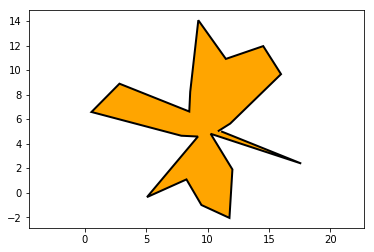

In [4]:
plot_graph(vertices)

In [21]:
def plot(moc, vertices, lon1=None, lat1=None, lon2=None, lat2=None):
    from matplotlib import path, patches
    import matplotlib.pyplot as plt
    from astropy.wcs.utils import skycoord_to_pixel

    # MOCPy offers a way to easily create an `astropy.wcs.WCS` object.
    # This define an ICRS aitoff projection.

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection=wcs)

    # Call to `mocpy.MOC.fill` for each of the three MOCs with various mpl styling keywords
    # to differentiate them from each other.
    moc.fill(ax=ax, wcs=wcs, edgecolor='r', facecolor='r', linewidth=1.0, fill=True, alpha=0.5)
    
    p = path.Path(np.vstack((x, y)).T)
    patch = patches.PathPatch(p, facecolor='orange', alpha=0.25, lw=2)
    ax.add_patch(patch)
    
    plt.axis("equal")
    plt.xlabel('ra')
    plt.ylabel('dec')
    plt.grid(color='black', ls='dotted')
    plt.title('from polygon')
    plt.show()
    plt.close()

CPU times: user 3.41 s, sys: 0 ns, total: 3.41 s
Wall time: 3.41 s


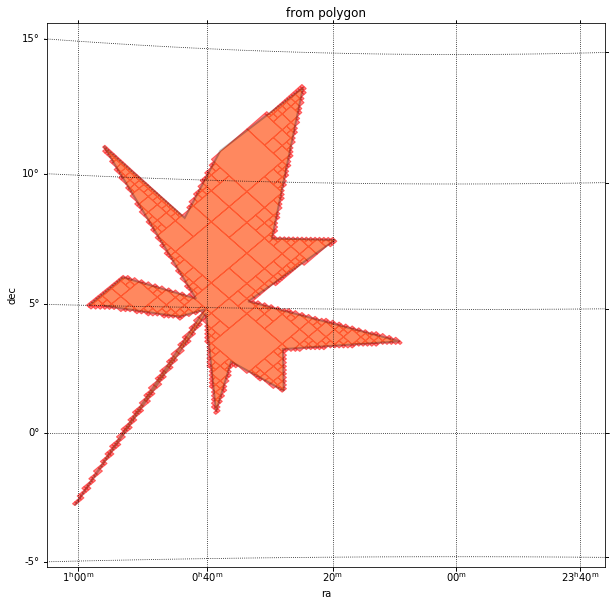

In [22]:
# Convert the vertices to lon and lat astropy quantities
lon, lat = vertices[:, 0] * u.deg, vertices[:, 1] * u.deg

# Define a vertex that is said to belongs to the MOC.
# It is important as there is no way on the sphere to know the area from
# which we want to build the MOC (a set of vertices delimits two finite areas).
inside = SkyCoord(ra=10, dec=5, unit="deg", frame="icrs")
%time moc = MOC.from_polygon(lon=lon, lat=lat, max_depth=9, inside=inside)
plot(moc, vertices, lon1=np.min(lon), lat1=np.min(lat), lon2=np.max(lon), lat2=np.max(lat))